<a href="https://colab.research.google.com/github/holdless/Colab/blob/master/colab_celebrity_faces_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
!ls '/content/drive/My Drive/5-celebrity-faces-dataset/'

train  val


In [197]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


load data

In [198]:
PATH = '/content/drive/My Drive/5-celebrity-faces-dataset/'
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

train_ben_dir = os.path.join(train_dir, 'ben_afflek')  # directory with our training cat pictures
train_elton_dir = os.path.join(train_dir, 'elton_john')  # directory with our training cat pictures
train_jerry_dir = os.path.join(train_dir, 'jerry_seinfeld')  # directory with our training cat pictures
train_madonna_dir = os.path.join(train_dir, 'madonna')  # directory with our training cat pictures
train_mindy_dir = os.path.join(train_dir, 'mindy_kaling')  # directory with our training cat pictures

val_ben_dir = os.path.join(val_dir, 'ben_afflek')  # directory with our validation cat pictures
val_elton_dir = os.path.join(val_dir, 'elton_john')  # directory with our validation cat pictures
val_jerry_dir = os.path.join(val_dir, 'jerry_seinfeld')  # directory with our validation cat pictures
val_madonna_dir = os.path.join(val_dir, 'madonna')  # directory with our validation cat pictures
val_mindy_dir = os.path.join(val_dir, 'mindy_kaling')  # directory with our validation cat pictures

In [199]:
num_ben_tr = len(os.listdir(train_ben_dir))
num_elton_tr = len(os.listdir(train_elton_dir))
num_jerry_tr = len(os.listdir(train_jerry_dir))
num_madonna_tr = len(os.listdir(train_madonna_dir))
num_mindy_tr = len(os.listdir(train_mindy_dir))

num_ben_val = len(os.listdir(val_ben_dir))
num_elton_val = len(os.listdir(val_elton_dir))
num_jerry_val = len(os.listdir(val_jerry_dir))
num_madonna_val = len(os.listdir(val_madonna_dir))
num_mindy_val = len(os.listdir(val_mindy_dir))

total_train = num_ben_tr + num_elton_tr + num_jerry_tr + num_madonna_tr + num_mindy_tr
total_val = num_ben_val + num_elton_val + num_jerry_val + num_madonna_val + num_mindy_val

print(total_train)
print(total_val)

93
25


some hyper-parameters

In [200]:
IMG_HEIGHT = 150
IMG_WIDTH = 150

embedding_dims = 128 #32.. don't set too high
batch_size = 25 #128.. must be smaller than dataset size... and可整除dataset data number, or metrics will fail to output
epochs = 100

data preparation

In [201]:
# create image generator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
#                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     #color_mode='grayscale'
                                                     )


Found 93 images belonging to 5 classes.


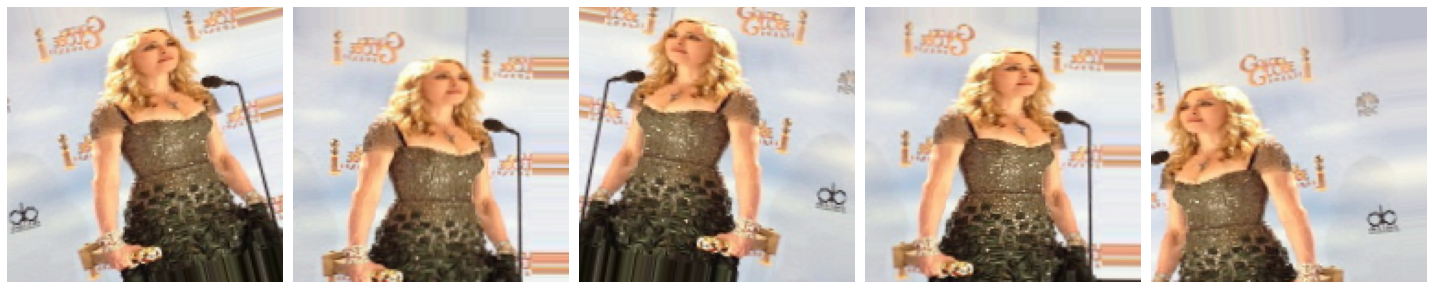

In [202]:
# Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        #ax.imshow(img[:,:,0], cmap='gray') #show gray level pic
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


In [203]:
# Create validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary',
                                                 #color_mode='grayscale'
                                                 )

Found 25 images belonging to 5 classes.


<Figure size 432x288 with 0 Axes>

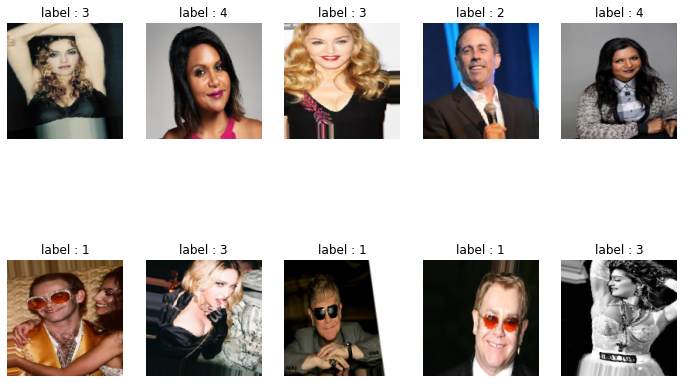

In [204]:
imgs, labels = next(train_data_gen)
ncols = 5
nrows = 2

plt.suptitle("faces in training dataset")
plt.figure(figsize = (12,8))
for i,(img,label) in enumerate(zip(imgs,labels)):
    if i > 9 :
        break
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img.reshape(IMG_HEIGHT,IMG_WIDTH,3), cmap = 'binary')
#    plt.imshow(img.reshape(IMG_HEIGHT,IMG_WIDTH), cmap = 'gray')
    plt.title("label : " + str(label.astype(np.int64)))
    plt.axis("off")
plt.show()

In [205]:
def augmentation_generator(input_gen, batch_size, embedding_dims):
    dummy_y = np.zeros((batch_size, embedding_dims + 1))
    for img, label in input_gen: 
#        a = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
        yield [img ,label.astype(np.int64)], dummy_y

In [206]:
train_aug = augmentation_generator(train_data_gen, batch_size, embedding_dims)
valid_aug = augmentation_generator(val_data_gen, batch_size, embedding_dims)

Build the model

In [221]:
def _cn_bn_relu(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same"):
    
    def f(input_x):
        
        x = input_x
        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,
                          kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        return x
    return f

def _dn_bn_relu(units = 256):
    def f(input_x):
        
        x = input_x
        x = tf.keras.layers.Dense(units = units)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        return x
    return f
    
def build_model(image_input, embedding_dims):
    
    x = _cn_bn_relu(filters = 64, kernel_size = (3,3))(image_input)
    x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
    x = _cn_bn_relu(filters = 64, kernel_size = (3,3))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    x = tf.keras.layers.Flatten()(x)
    x = _dn_bn_relu(units = 256)(x)
    x = _dn_bn_relu(units = 128)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = _dn_bn_relu(units = 64)(x)
    x = tf.keras.layers.Dense(units = embedding_dims, name = "embedding_layer")(x)
    # 2020.6.23 hiroshi: add l-2 normalization for triplet loss input argument
    x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    return x

#image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0].shape, name = "image_input")
image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0][0].shape, name = "image_input")
label_input = tf.keras.layers.Input(shape = (1,), name = "label_input")

base_model = build_model(image_input, embedding_dims)
output = tf.keras.layers.concatenate([label_input, base_model])

model = tf.keras.models.Model(inputs = [image_input, label_input], outputs = [output])
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 150, 150, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 150, 150, 64) 256         conv2d_48[0][0]                  
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 150, 150, 64) 0           batch_normalization_120[0][0]    
___________________________________________________________________________________________

training embedding model


In [222]:
def triplet_loss(y_true, y_pred, margin = 1.2):
    
    del y_true
    
    labels = y_pred[:,:1]
    labels = tf.dtypes.cast(labels, tf.int32)
    labels = tf.reshape(labels, (tf.shape(labels)[0],))
    
    embeddings = y_pred[:,1:]
    #return tfa.losses.triplet_semihard_loss(labels = labels, embeddings = embeddings, margin = margin)
    return tfa.losses.triplet_semihard_loss(y_true=labels, y_pred=embeddings, margin=margin)

In [223]:
import tensorflow_addons as tfa

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=triplet_loss)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, mode = 'min', verbose = 1, min_lr = 1e-6)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min')
steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size

#epochs = 20

history = model.fit_generator(train_aug, steps_per_epoch = steps_per_epoch,
                              epochs = epochs, verbose = 1,
                              validation_data = valid_aug, validation_steps = validation_steps,
                              callbacks = [reduce_lr,es],
                              shuffle = True)

Epoch 1/100
3/3 [==============================] - 1s 311ms/step - loss: 1.1515 - val_loss: 1.1936 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 1s 222ms/step - loss: 1.1221 - val_loss: 1.1942 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 1s 244ms/step - loss: 1.1136 - val_loss: 1.1942 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 1s 255ms/step - loss: 1.1176 - val_loss: 1.1917 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 1s 228ms/step - loss: 1.0941 - val_loss: 1.1885 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 1s 233ms/step - loss: 1.0818 - val_loss: 1.1886 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 1s 243ms/step - loss: 1.0780 - val_loss: 1.1930 - lr: 0.0010
Epoch 8/100
3/3 [==============================] - 1s 244ms/step - loss: 1.0867 - val_loss: 1.1841 - lr: 0.0010
Epoch 9/100
3/3 [==============================] - 1s 224ms/step - loss: 1.0686 - val_loss: 1.1863 - lr:

show training info

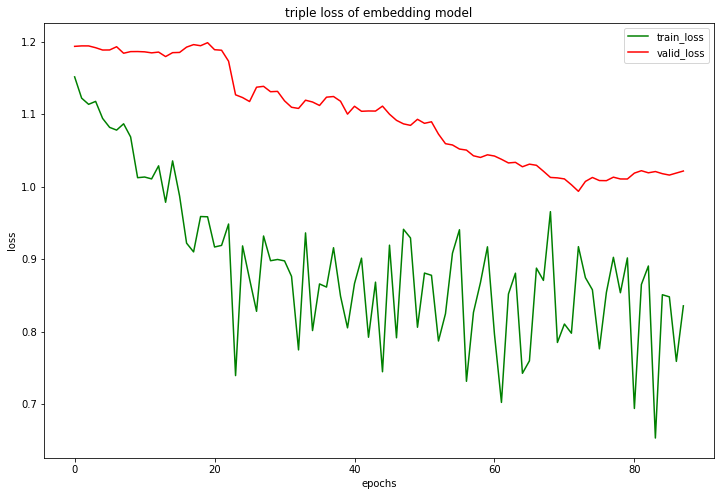

In [224]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'], '-', label = 'valid_loss', color = 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('triple loss of embedding model')
plt.legend()
plt.show()

In [225]:
#Transfer the weights from original model to embedding model

image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0][0].shape)
embedding_output = build_model(image_input, embedding_dims = embedding_dims)
embedding_model = tf.keras.models.Model(inputs = [image_input], outputs = [embedding_output])

for idx in range(1,18):
    target_layer = embedding_model.layers[idx]
    source_layer = model.layers[idx]
    target_layer.set_weights(source_layer.get_weights())
    
embedding_model.layers[-1].set_weights(model.layers[-2].get_weights())

embedding_model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_125 (Bat (None, 150, 150, 64)      256       
_________________________________________________________________
activation_125 (Activation)  (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_126 (Bat (None, 75, 75, 64)        256

load all train and valid data


Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


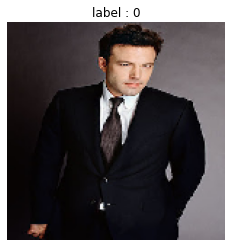

In [226]:
image_gen = ImageDataGenerator(rescale=1./255)
train_all_gen = image_gen.flow_from_directory(batch_size=total_train,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     #color_mode='grayscale'
                                                     )
val_all_gen = image_gen.flow_from_directory(batch_size=total_val,
                                                     directory=val_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     #color_mode='grayscale'
                                                     )
all_train_img, all_train_label = next(train_all_gen)
all_val_img, all_val_label = next(val_all_gen)

imgType = 'val'
idx = 2
imgNameStr = 'all_' + imgType + "_img[idx]"
#plt.imshow(eval(imgNameStr).reshape(IMG_HEIGHT,IMG_WIDTH), cmap = 'gray')
plt.imshow(eval(imgNameStr).reshape(IMG_HEIGHT,IMG_WIDTH,3), cmap = 'binary')
plt.title("label : " + str(all_train_label[idx].astype(np.int64)))
plt.axis("off")
plt.show()

visualization, t-sne

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


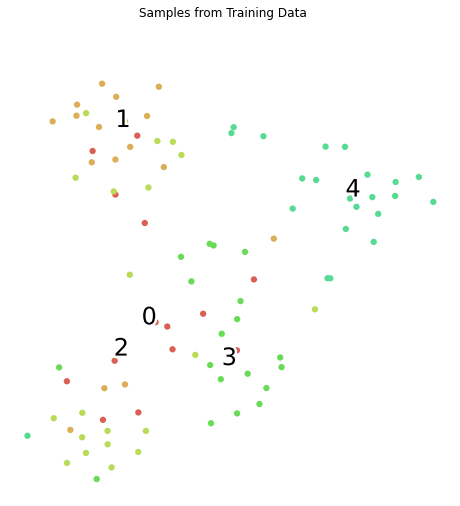

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


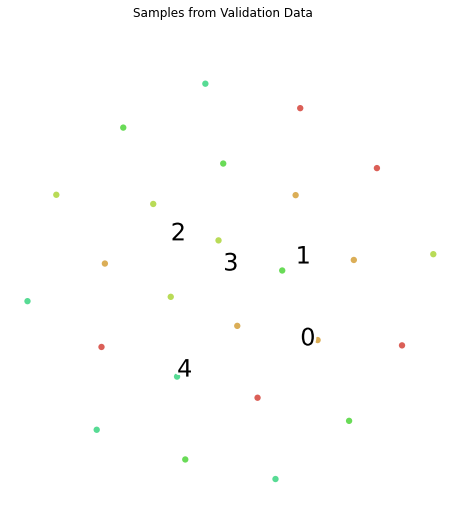

In [227]:
from sklearn.manifold import TSNE



import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

train_x_embeddings = embedding_model.predict(all_train_img)
valid_x_embeddings = embedding_model.predict(all_val_img)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(train_x_embeddings)
scatter(train_tsne_embeds, all_train_label, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(valid_x_embeddings)
scatter(eval_tsne_embeds, all_val_label, "Samples from Validation Data")
